*Practical Data Science 20/21*
# Programming Assignment 5 - Create your own App

In this programming assignment you'll build a model that serves as a foundation for your own app. To this end, you will create your own dataset, build a deep learning model on this data, and deploy it!

In [262]:
!pip install -Uqq fastai  # upgrade fastai on colab
from fastai.vision.all import *
from fastai.vision.widgets import *
from bs4 import BeautifulSoup
import requests
import pandas as ps
import re
import json
from fastcore.foundation import L

__Google Drive integration__

If you want to store and access your downloaded data for this assignment you can use the following code:

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir /content/drive/My\ Drive/pds_a5
%cd /content/drive/My\ Drive/pds_a5

Mounted at /content/drive
mkdir: cannot create directory ‘/content/drive/My Drive/pds_a5’: File exists
/content/drive/My Drive/pds_a5


## Develop an Application Idea

___Free your mind - this part is totally up to you.___

Think of an app that you'd like to build.
*   What useful app have you been missing?
*   Do you have any hobbies an app could be helpful for?
*   Is this a suitable classification or regression task? 
*   How could you get the data?


In [3]:
# beerino: an app for classifying different bottles of beer (like the Vivino App). On top of the classification, 
# I want to retrieve Data from bierbasis.de, indicating, how good a beer is

You can get an inspiration from these Apps:

<table>
<tr>
<td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/5.png"> <br><a href="https://forums.fast.ai/t/share-your-work-here/27676/400">Guitar Classifier</a> by Christian Werner</td><td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/6.png"><br><a href="https://forums.fast.ai/t/share-your-work-here/27676/340">Healthy or Not!</a> by Nikhil Utane </td><td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/7.png"> <br><a href="https://forums.fast.ai/t/share-your-work-here/27676/333">Hummingbird Classifier</a> by Nissan Dookeran</td>
</tr><tr>
<td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/8.png"> <br><a href="https://forums.fast.ai/t/share-your-work-here/27676/409">Edible Mushroom?</a> by Ramon</td><td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/9.png"><br> <a href="https://forums.fast.ai/t/share-your-work-here/27676/387">Cousin Recognizer</a> by Charlie Harrington</td><td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/10.png"><br> <a href="https://forums.fast.ai/t/share-your-work-here/27676/386">Emotion Classifier</a> by Ethan Sutin and Team 26</td>
</tr><tr>
<td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/11.png"> <br><a href="https://forums.fast.ai/t/share-your-work-here/27676/350">American Sign Language</a> by Keyur Paralkar</td><td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/12.png"> <br><a href="https://forums.fast.ai/t/share-your-work-here/27676/355">Your City from Space</a> by Henri Palacci</td><td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/13.png"> <br><a href="https://forums.fast.ai/t/share-your-work-here/27676/367">Univariate TS as images using Gramian Angular Field</a> by Ignacio Oguiza</td>
</tr><tr>
<td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/14.png"> <br><a href="https://forums.fast.ai/t/share-your-work-here/27676/348">Face Expression Recognition</a> by Pierre Guillou</td><td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/15.png"><br><a href="https://forums.fast.ai/t/share-your-work-here/27676/352">Tumor-normal sequencing</a> by Alena Harley</td><td>  </td>
</tr><table>

## Creating your own Dataset

Now you need to construct a dataset that allows you to train a model for your app. You learned about how to create a dataset in Lecture 7.

Here, you can follow the steps from the lecture or look into the following ressources:

*   A [tool](https://github.com/toffebjorkskog/ml-tools/blob/master/gi2ds.md) for excluding irrelevant images from Google Image Search results beforehand by @melonkernel
*   See this [post](https://www.christianwerner.net/tech/Build-your-image-dataset-faster/) about an alternative image downloader/cleaner by @cwerner
*   Of course, you can use your own data/images :) 

### 1. Dowload the data 
- You may use the helper functions from the lecture to get the image URLs
- Create a new folder at your defined `path`
- Use `download_image` to download the images into the corresponding (sub-)directories

In [263]:
links = []
titles = []
for i in range(1, 12):
  URL = "https://bierbasis.de/biere-nach-laendern/deutschland/page/" + str(i)
  results = requests.get(URL)
  src = results.content
  soup = BeautifulSoup(src, 'lxml')
  classes = soup.find_all(class_="img-responsive col-xs-9")
  for j in range(len(classes)):
    links.append(classes[j]['href'])
    titles.append(classes[j]['title'])

# soup.find_all(class_="img-responsive col-xs-9")[i]['href']

In [ ]:
titles

In [5]:
print('items_links: ', len(links), 'items: titles: ', len(titles))

items_links:  198 items: titles:  198


In [4]:
path = Path('/content/drive/MyDrive/pds_a5')

In [6]:
def search_images_ddg(key,max_n=150):
    """Search for 'key' with DuckDuckGo and return a unique urls of 'max_n' images
    (Adopted from https://github.com/deepanprabhu/duckduckgo-images-api and 
    https://github.com/fastai/fastbook/blob/master/utils.py)
    """
    url        = 'https://duckduckgo.com/'
    params     = {'q':key}
    res        = requests.post(url,data=params)
    searchObj  = re.search(r'vqd=([\d-]+)\&',res.text)
    if not searchObj: print('Token Parsing Failed !'); return
    requestUrl = url + 'i.js'
    headers    = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:71.0) Gecko/20100101 Firefox/71.0',
                 'referer': 'https://duckduckgo.com/'}
    params     = (('l','us-en'),('o','json'),('q',key),('vqd',searchObj.group(1)),('f',',,,'),('p','1'),('v7exp','a'))
    urls       = []
    while True:
        try:
            res  = requests.get(requestUrl,headers=headers,params=params)
            data = json.loads(res.text)
            for obj in data['results']:
                urls.append(obj['image'])
                max_n = max_n - 1
                if max_n < 1: return L(set(urls))     # dedupe
            if 'next' not in data: return L(set(urls))
            requestUrl = url + data['next']
        except:
            pass

In [8]:
ims = search_images_ddg(titles[0])
len(ims)

135

In [45]:
filenames = pd.Series(links).str.replace('/bier/', '')
URL = 'https://bierbasis.de'

In [10]:
'''
for i in range(200):
    o = filenames[i]
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_ddg(titles[i], 50)
    download_images(dest, urls=results)
'''

'\nfor i in range(200):\n    o = filenames[i]\n    dest = (path/o)\n    dest.mkdir(exist_ok=True)\n    results = search_images_ddg(titles[i], 50)\n    download_images(dest, urls=results)\n'

### 2. Verify Images
- First, create a list of all your images
- Use `verify_images` and `unlink` to remove broken images

In [12]:
fns = get_image_files(path)

In [14]:
failed = verify_images(fns)

In [9]:
failed

(#0) []

In [ ]:
failed.map(Path.unlink)

In [123]:
# prepare transparent images (png) with white background from: 
# https://stackoverflow.com/questions/9166400/convert-rgba-png-to-rgb-with-pil/9459208#9459208
'''
for png_path in get_files(path, extensions = '.png'):
  png = Image.open(png_path).convert('RGBA')
  background = Image.new('RGBA', png.size, (255,255,255))
  alpha_composite = Image.alpha_composite(background, png)
  alpha_composite.save(png_path, 'PNG', quality=80) '''

### 3. Create the DataBlock
For this, you need to think of:
- What kinds of data we are working with
- How to get the list of items
- How to label these items
- How to create the validation set

Use `RandomResizedCrop` for `item_tfms`with an image size of 224 px, and the appropriate `aug_transforms` as `batch_tfms`.

In [6]:
beers = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.25, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224),
    batch_tfms=aug_transforms())

### 4. Create the DataLoaders

In [7]:
dls = beers.dataloaders(path)

### 5. Take a look at some of your pictures. 
Does everything look as expected?

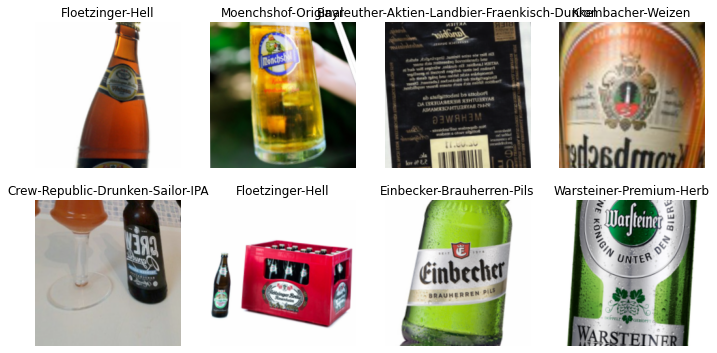

In [8]:
dls.train.show_batch(max_n=8, nrows=2, unique=False)

### Modeling

### 6. Create a learner

Create an appropriate learner for your data
- Choose an appropriate model [architecture](https://fastai1.fast.ai/vision.models.html)
- Choose appropriate [metrics](https://docs.fast.ai/metrics.html) for your task

In [9]:
learn = cnn_learner(dls, resnet50, metrics=(error_rate, top_k_accuracy))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


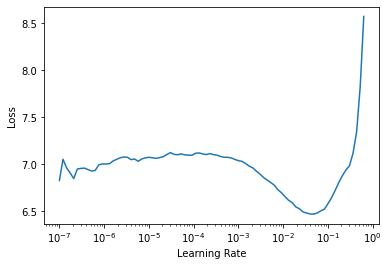

In [15]:
lr_min, lr_steep = learn.lr_find()

In [265]:
with open("available_categories.txt", "w") as output:
    output.write(str(titles))

In [266]:
with open("available_categories.txt", 'w') as output:
    for row in titles:
        output.write(str(row) + '\n')

In [ ]:
learn.save('stage-0')

### 7. Fit the model

Use your knowdledge on model training to fit your model!

In [20]:
learn.fit_one_cycle(4, (lr_min + lr_steep)/2) #resnet 34: err_rate: 0.361006 	topk: 0.831120 	
learn.save('stage-1-res50')

epoch,train_loss,valid_loss,error_rate,top_k_accuracy,time
0,4.193023,3.011450,0.647366,0.644518,03:32
1,2.875849,2.068423,0.446132,0.783104,03:31
2,1.932026,1.589260,0.354058,0.834836,03:29
3,1.346612,1.480973,0.324632,0.847176,03:30


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(

Path('models/stage-1-res50.pth')

In [40]:
learn.load('stage-1')

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


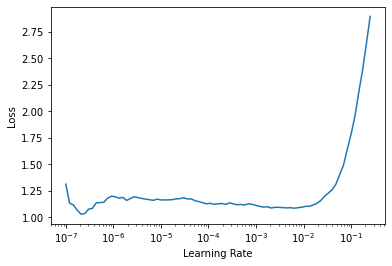

In [21]:
lr_min, lr_steep = learn.lr_find()

In [25]:
learn.load('stage-1-res50')

In [26]:
learn.unfreeze()
learn.fit_one_cycle(10, lr_max=slice(0.00001, 0.001))

epoch,train_loss,valid_loss,error_rate,top_k_accuracy,time
0,1.116943,1.437190,0.320361,0.853346,03:38
1,1.071354,1.390020,0.301851,0.857617,03:38
2,0.974745,1.365726,0.292833,0.859041,03:37
3,0.819535,1.335598,0.298054,0.868533,03:36
4,0.683060,1.292360,0.280494,0.880399,03:36
5,0.569294,1.261312,0.266255,0.880873,03:37
6,0.481172,1.237729,0.269578,0.881348,03:37
7,0.420424,1.234865,0.265306,0.883721,03:36
8,0.382617,1.229104,0.262458,0.885145,03:36
9,0.363917,1.224248,0.261984,0.884670,03:38


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  

In [42]:
learn.save('stage-2')
# resnet18; error_rate:0.368197 	topk:0.823947

Path('models/stage-2.pth')

In [ ]:
learn.save('stage-2.1')
# resnet34; error_rate:0.314991 	top_5:0.857211

In [24]:
learn.save('stage-2-res50')
# resnet50; error_rate:0.236355 	top_5:0.897485

Path('models/stage-2-res50.pth')

In [10]:
learn = learn.load('stage-2-res50')

### 8. Evaluate the model

You' ve already seen many ways to evaluate a model. Evaluate your model in a qualitative and quantitative manner.

In [11]:
interp = ClassificationInterpretation.from_learner(learn)

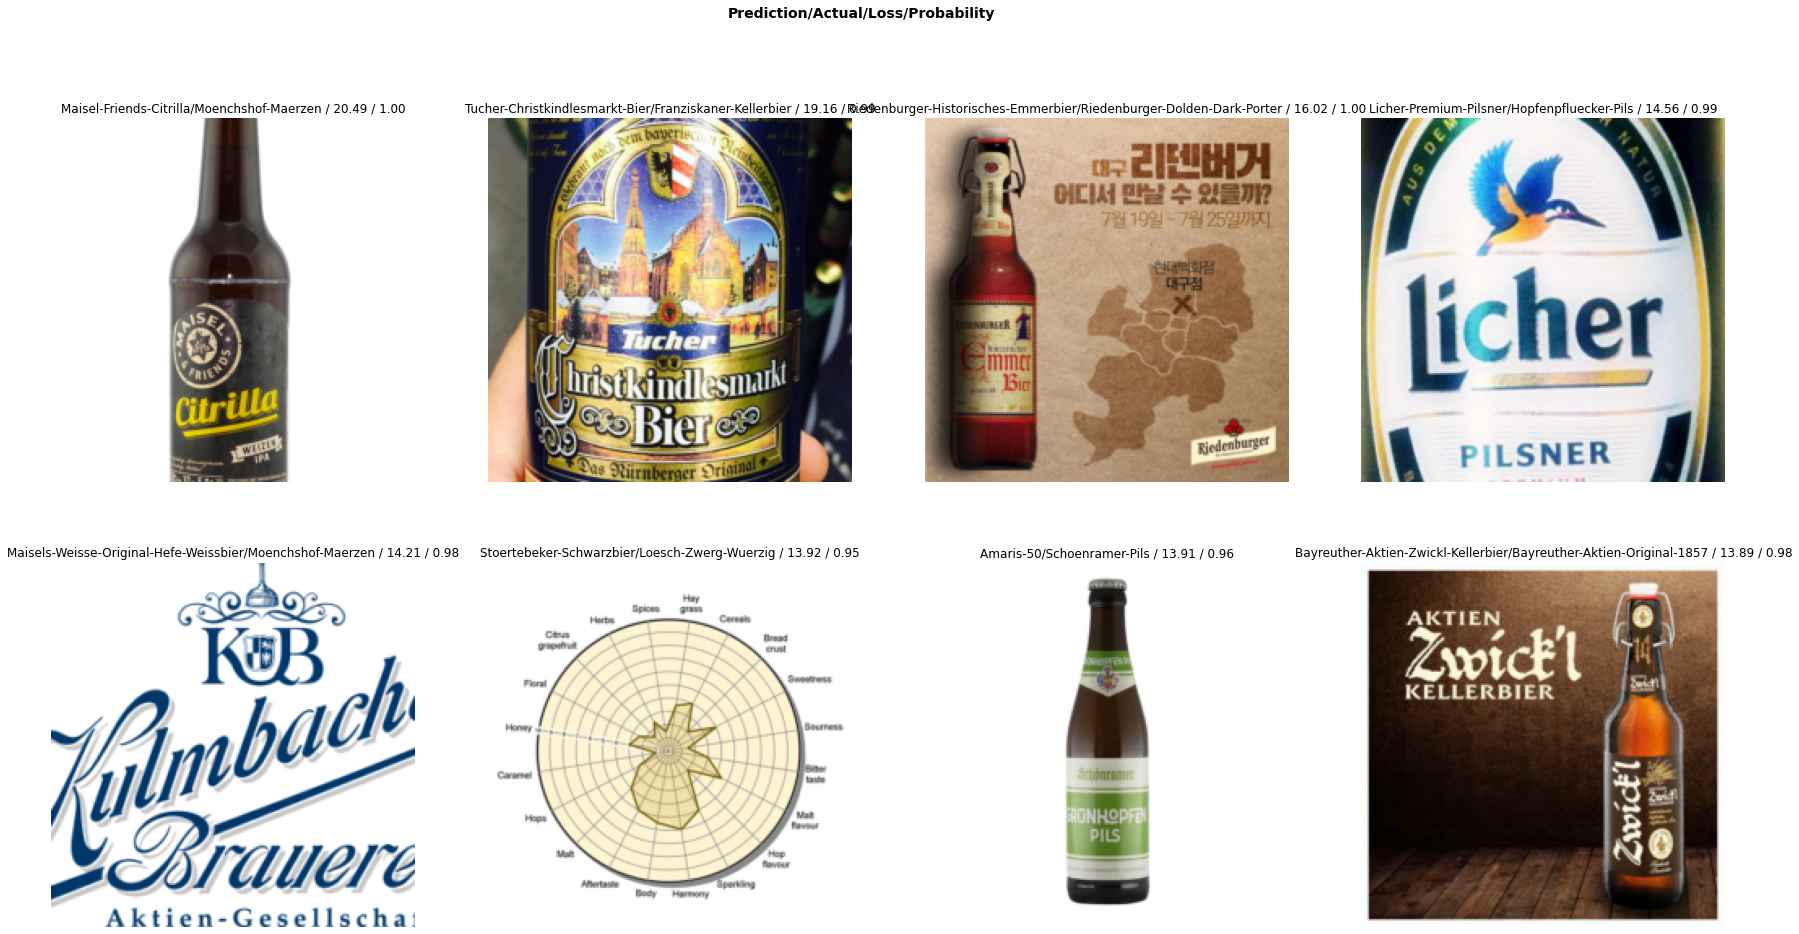

In [13]:
interp.plot_top_losses(8, figsize=(30,15))

In [131]:
# interp.most_confused(min_val=2)

### 9. Clean your data

Based on the evaluation, you may want to clean your data using the `ImageClassifierCleaner`.
- Remeber to delete the selected data after using the cleaner:
    ```python
    for idx in cleaner.delete(): cleaner.fns[idx].unlink()
    ```
    
    
- Once we've cleaned up our data, we can retrain our model. 



In [ ]:
'''
cleaner = ImageClassifierCleaner(learn)
'''
# RAM did not fit; generally data is still very dirty, but 200categories is too 
# much to clean within this project
# did the initial cleaning on the data in google drive

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


## Turning Your Model into an Online Application

Now, take your app into production. You can follow the steps from the lecure:

- Export your model via `learn.export`
- Upload your model to [Github Releases](https://docs.github.com/en/free-pro-team@latest/github/administering-a-repository/about-releases) to make it publicly available at your repository.
- Create and upload a new notebook that only contains the necassary code and IPython widgets for your App. 
    - Remeber to download the exported model from *Github Releases*
    - Include a brief description of your app and the functionalities
- Publish your web app on [Binder](https://mybinder.org/) using Voilà

You can use the [example](https://github.com/pds2021/course/blob/main/nbs/07_Bear_App.ipynb) from the lecture as an orientation.

If you're familiar with the world of web application development, you're free to use these skills and all your tools and ressources!

In [14]:
from fastai.vision.widgets import *

In [15]:
learn.export()
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [16]:
learn_inf = load_learner(path/'export.pkl')

In [18]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

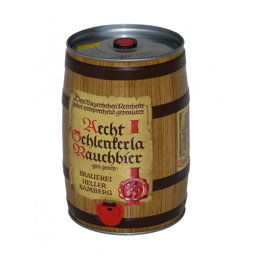

In [19]:
img = PILImage.create(btn_upload.data[-1])
img.to_thumb(256,256)

## In progress: choose next probable prediction from dropdown menu

In [237]:
Options = learn_inf.dls.vocab[pd.Series(probs).sort_values(ascending=False)[1:5].index]
Probs = round(pd.Series(probs).sort_values(ascending=False)[1:5], 5)

alternatives = widgets.Dropdown(
    options=[(Options[i] + '; Prob: ' + str(Probs.iloc[i]), Options[i]) for i in range(len(Options))],
    description='weitere Optionen:',
    disabled=False,
)

In [ ]:
"https://stackoverflow.com/questions/34020789/ipywidgets-dropdown-widgets-what-is-the-onchange-event"

In [254]:
while pred == None:
  alternatives = widgets.Dropdown(
    options=[],
    description='weitere Optionen:',
    disabled=False,)

In [259]:
btn_run = widgets.Button(description='Rerun')

In [234]:
def bar(x):
    '''
        I am intentionally passing what it is made of so you can see the output.
    '''
    print(x,'\n') # Whole object
    #print(x.new,'\n') # New value

alternatives.observe(bar, names='value')

In [251]:
# btn_run.on_click(rerun('new')) #input with new data for informations
VBox([widgets.Label('switch your beer!'), 
      alternatives, btn_run])

TypeError: ignored

In [213]:
def get_user_selection(a): # A default arg is needed here, I am guessing to pass self
    # Displays the current value of dropbox1 and dropbox two
    display(alternatives.value)

In [258]:
display(alternatives.value)

None

In [166]:
Options

(#4) ['Weltenburger-Barock-Dunkel','Weissenoher-Altfraenkisches-Klosterbier','Riedenburger-Historisches-Emmerbier','Paulaner-Oktoberfestbier']

In [158]:
.iloc[0]

1e-04

In [142]:
pd.Series(probs).sort_values(ascending=False)[1]

4.3420494e-07

In [37]:
pred,pred_idx,probs = learn_inf.predict(img)

In [40]:
learn_inf.dls.vocab[pd.Series(probs).sort_values(ascending=False)[1:5].index]

(#4) ['Weltenburger-Barock-Dunkel','Weissenoher-Altfraenkisches-Klosterbier','Riedenburger-Historisches-Emmerbier','Paulaner-Oktoberfestbier']

In [36]:
pd.Series(probs).sort_values()[-5:]

134    0.000039
148    0.000081
190    0.000089
193    0.000101
2      0.999390
dtype: float32

In [41]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: Aecht-Schlenkerla-Rauchbier-Maerzen; Probability: 0.9994')

## Finally, Provide a Link to Your App

https://mybinder.org/v2/gh/pds2021/a5-LukasHoerner/assignment_5?urlpath=%2Fvoila%2Frender%2Fbeerino.ipynb